In [269]:
import numpy as np 
import pandas as pd # data handling
from tqdm.notebook import tqdm # measuring for loops runtime
import matplotlib.pyplot as plt # plot 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [277]:
#path = "drive/MyDrive/MAS/Data/Output_GAMA/Data" # path to folder & files
path = "D:/Simone/Restrictions_Beta0.05_30k/" # My Drive\MAS\Data\Output_GAMA\Data\People\Restrictions_Beta0.05_30k
people_path = path #+ "/People" # path to agents files , gama export
num_people = 30030 
curfew_time = [18,19,20] # hour when the curfew starts
curfew_delay = [5, 10] #days after the start of the simulation for curfew 

people_files = []

for i in tqdm(range(0,num_people)):
    people_files.append(people_path + "people" + str(i) + ".txt")

  0%|          | 0/1020 [00:00<?, ?it/s]

In [271]:
def preprocess_people(people_file):

    DF_people = pd.read_csv(people_file, sep = ",", names = ["cycle","beta","curfew_time", "curfew_delay", "working_place","living_place","is_infected","is_immune","is_dead"])
    DF_people = DF_people[DF_people["cycle"] != "cycle"]
    DF_people = DF_people.reset_index(drop = True)

    DF_people["cycle"] = DF_people["cycle"].astype(np.int16)  # dtype conversion
    DF_people["beta"] = DF_people["beta"].astype(np.float32)
    DF_people["curfew_time"] = DF_people["curfew_time"].astype(np.int16)
    DF_people["curfew_delay"] = DF_people["curfew_delay"].astype(np.int16)
    DF_people = DF_people.replace({"is_infected":{"true":1, "false":0}})
    DF_people = DF_people.replace({"is_immune":{"true":1, "false":0}})
    DF_people = DF_people.replace({"is_dead":{"true":1, "false":0}}) 

    DF_people["is_susceptible"] = 1 - (DF_people.is_infected + DF_people.is_immune + DF_people.is_dead)

    mean_ =  DF_people.groupby(['curfew_time', 'curfew_delay', 'cycle'])['is_susceptible', 'is_immune', 'is_infected', 'is_dead'].mean()
    var_  =  DF_people.groupby(['curfew_time', 'curfew_delay', 'cycle'])['is_susceptible', 'is_immune', 'is_infected', 'is_dead'].var()

    return mean_, var_

In [272]:
mean_0, var_0 = preprocess_people(people_files[0])
mean = mean_0
var = var_0 
for file in tqdm(people_files[1:], total = len(people_files)-1):
    pivot_mean, pivot_var = preprocess_people(file)
    mean += pivot_mean
    var += pivot_var 

  0%|          | 0/30029 [00:00<?, ?it/s]

In [273]:
n_batch = 30
aggr_people = mean.reset_index()
aggr_people["days"] = aggr_people["cycle"]/24
aggr_people_var = var.reset_index()
aggr_people_var["days"] = aggr_people_var["cycle"]/24
aggr_people_var["is_susceptible"] = aggr_people_var["is_susceptible"] /n_batch
aggr_people_var["is_immune"] = aggr_people_var["is_immune"]/n_batch
aggr_people_var["is_infected"] = aggr_people_var["is_infected"]/n_batch
aggr_people_var["is_dead"] = aggr_people_var["is_dead"]/n_batch
aggr_people["std_infected"] = np.sqrt(aggr_people_var["is_infected"])
aggr_people["lower_bound"] = aggr_people["is_infected"] - 3*aggr_people["std_infected"] # 3 sigma
aggr_people["upper_bound"] = aggr_people["is_infected"] + 3*aggr_people["std_infected"]

In [274]:
curfew_0 = aggr_people[(aggr_people.curfew_time == curfew_time[0]) & (aggr_people.curfew_delay == curfew_delay[0]) ] # corresponding to beta = 0.075...... 
curfew_1 = aggr_people[(aggr_people.curfew_time == curfew_time[1]) & (aggr_people.curfew_delay == curfew_delay[0]) ]
curfew_2 = aggr_people[(aggr_people.curfew_time == curfew_time[2]) & (aggr_people.curfew_delay == curfew_delay[0]) ]
#beta_2 = aggr_people[aggr_people.beta == aggr_people.iloc[250,0]] # corresponding to beta = 0.075...... 
#beta_3 = aggr_people[aggr_people.beta == aggr_people.iloc[370,0]] # corresponding to beta = 0.1...... 

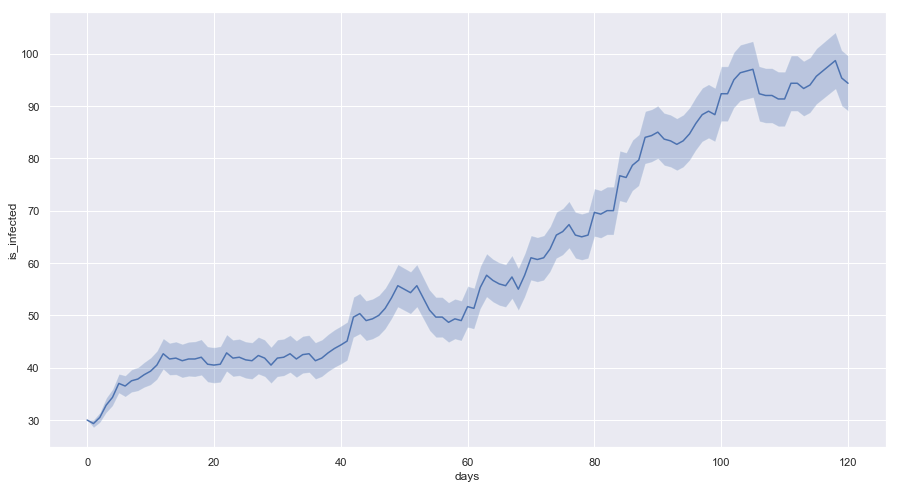

In [275]:
# Beta = .05 curfew_time = 18, curfew_delay = 5
sns.set_theme()
plt.figure(figsize = (15,8))
sns.lineplot(
    data= curfew_0,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(curfew_0.days, curfew_0.lower_bound, curfew_0.upper_bound, alpha=.3)
plt.show()

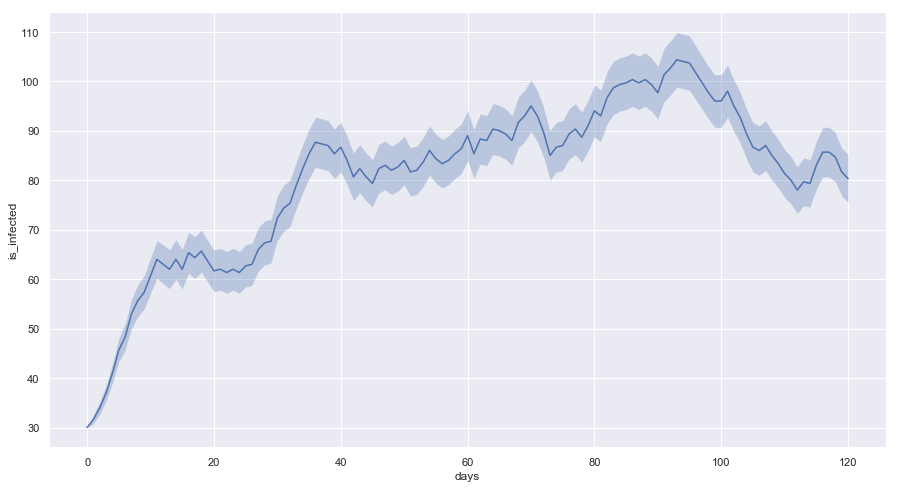

In [267]:
# Beta = .05 curfew_time = 18, curfew_delay = 10 
sns.set_theme()
plt.figure(figsize = (15,8))
sns.lineplot(
    data= curfew_1,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(curfew_1.days, curfew_1.lower_bound, curfew_1.upper_bound, alpha=.3)
plt.show()

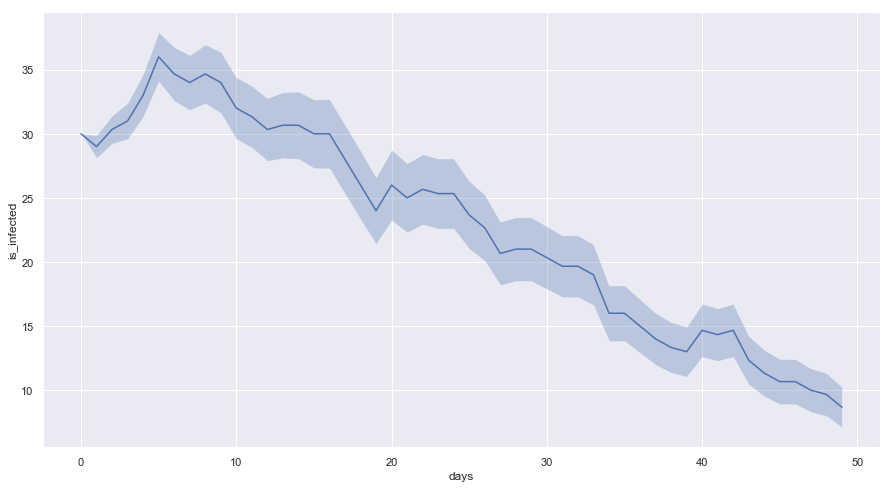

In [276]:
# Beta = .05 curfew_time = 19, curfew_delay = 5 

sns.set_theme()
plt.figure(figsize = (15,8))
sns.lineplot(
    data= curfew_2,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(curfew_2.days, curfew_2.lower_bound, curfew_2.upper_bound, alpha=.3)
plt.show()

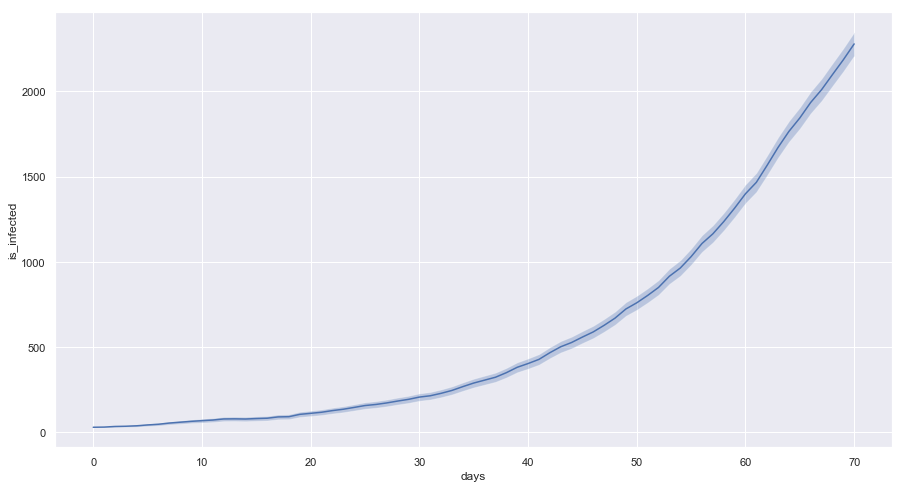

In [41]:
# Beta = 0.1
sns.set_theme()
plt.figure(figsize = (15,8))
sns.lineplot(
    data= curfew_0,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(curfew_0.days, curfew_0.lower_bound, curfew_0.upper_bound, alpha=.3)
plt.show()

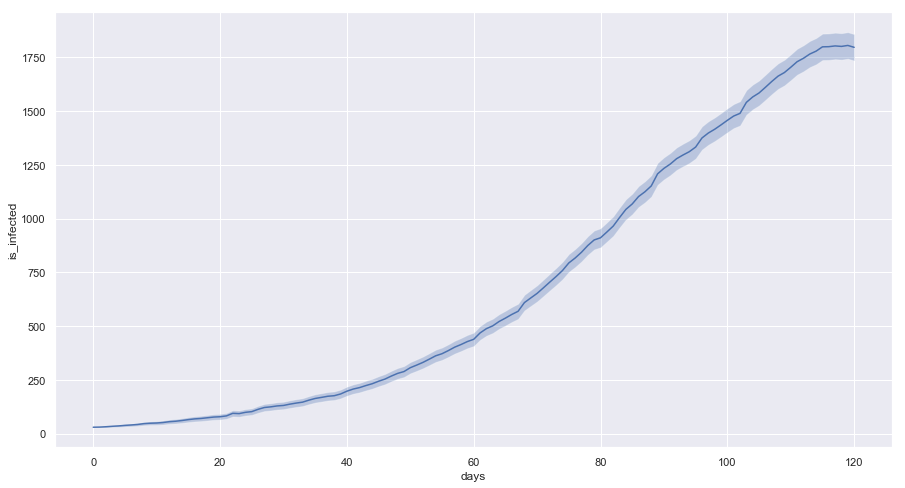

In [161]:
sns.set_theme()
plt.figure(figsize = (15,8))
sns.lineplot(
    data= beta_1,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_1.days, beta_1.lower_bound, beta_1.upper_bound, alpha=.3)
plt.show()

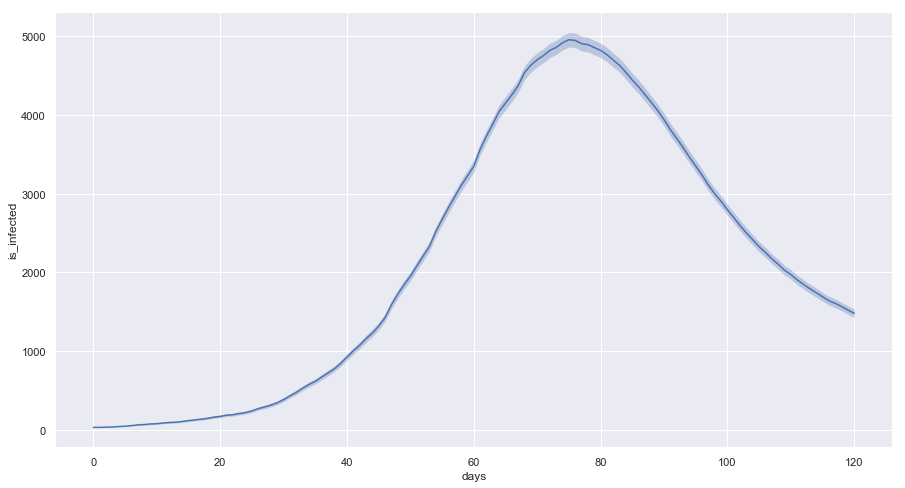

In [162]:
sns.set_theme()
plt.figure(figsize = (15,8))
sns.lineplot(
    data= beta_2,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_2.days, beta_2.lower_bound, beta_2.upper_bound, alpha=.3)
plt.show()

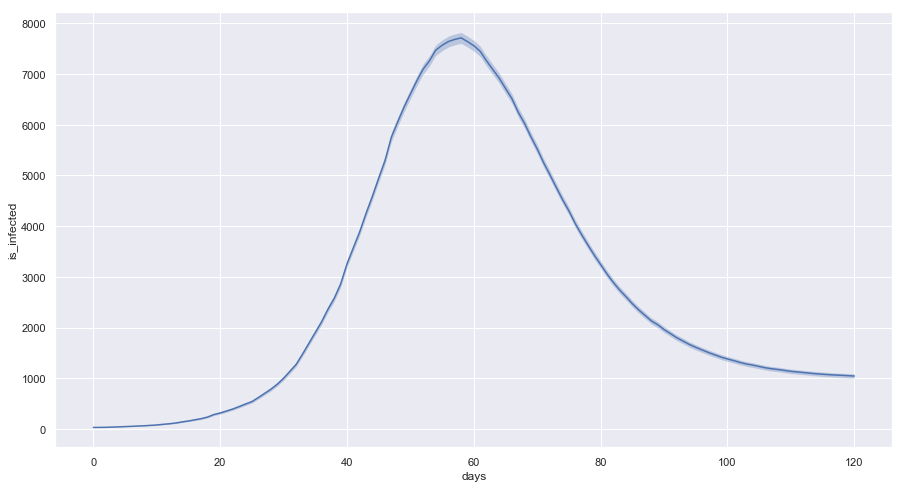

In [163]:
sns.set_theme()
plt.figure(figsize = (15,8))
sns.lineplot(
    data= beta_3,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_3.days, beta_3.lower_bound, beta_3.upper_bound, alpha=.3)
plt.show()

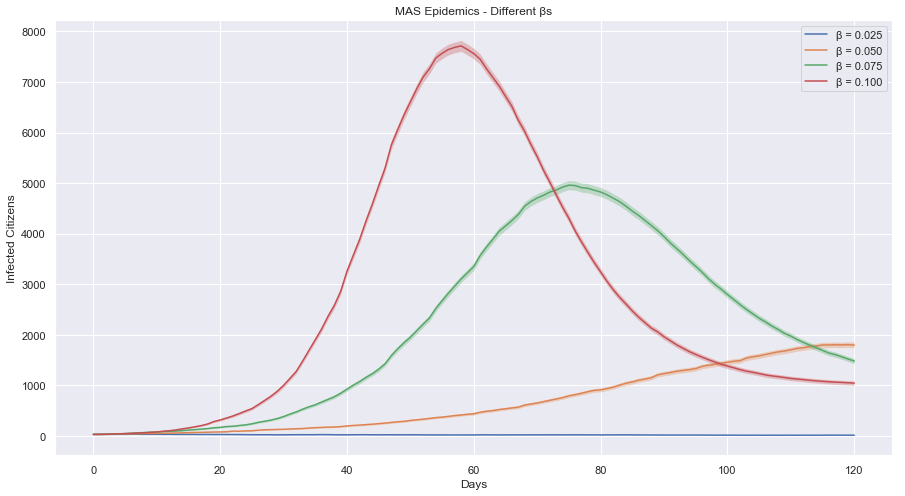

In [165]:
## Beta == 0.025....
sns.set_theme()
plt.figure(figsize = (15,8))
a = sns.lineplot(
    data= beta_0,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_0.days, beta_0.lower_bound, beta_0.upper_bound, alpha=.3)

## Beta == 0.05....
b = sns.lineplot(
    data= beta_1,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_1.days, beta_1.lower_bound, beta_1.upper_bound, alpha=.3)

## Beta == 0.075....

c = sns.lineplot(
    data= beta_2,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_2.days, beta_2.lower_bound, beta_2.upper_bound, alpha=.3)


## Beta == 0.1....

d = sns.lineplot(
    data= beta_3,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_3.days, beta_3.lower_bound, beta_3.upper_bound, alpha=.3)
#custom_betas = [beta_0.days, beta_1.days, beta_2.days, beta_3.days]
#plt.legend(custom_betas, ["$\beta = 0.025$","$\beta = 0.05$","$\beta = 0.075$","$\beta = 0.1$" ])
d.legend(labels = ["β = 0.025","β = 0.050","β = 0.075","β = 0.100" ])
plt.xlabel("Days")
plt.ylabel("Infected Citizens")
plt.title("MAS Epidemics - Different βs")
plt.savefig("betas_evolution.png", dpi = 600)
plt.show()